# 1. Imports

## 1.1. Libraries

In [208]:
import inflection
import datetime
import math

import random
import numpy as np
import pandas as pd
import pandas_profiling as pr
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt

from IPython.core.display      import display, HTML
from IPython.display           import Image

from boruta import BorutaPy

from scipy import stats as ss

from keras import models as ml
from keras import layers as l

## 1.2. Helper Functions

In [201]:
def jupyter_settings():
    
    !matplotlib inline
    !pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 12
    
    display(HTML("<style>.container { width:90% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
    
def num_analysis(num_attributes):
    # Cemtral tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
    return m


def cramer_v (x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

In [106]:
jupyter_settings()

'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 1.3. Data

In [107]:
# train_users_2

df_raw = pd.read_csv('data/train_users_2.csv')

In [108]:
df_raw.shape

(213451, 16)

In [109]:
# sessions

df_sessions = pd.read_csv('data/sessions.csv')

In [110]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [111]:
# granulariadade, cada usuario realiza varias ações, como registrado no csv 'sessions'

df_sessions.sort_values('user_id').head()

# cada ação pode ser convertida a uma nova variável, com indicação de ocorrência ou não por parte do usuário

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3573962,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,1767.0
3573933,00023iyk9l,requested,view,p5,Mac Desktop,702.0
3573934,00023iyk9l,requested,view,p5,Mac Desktop,3827.0
3573935,00023iyk9l,travel_plans_current,view,your_trips,Mac Desktop,474.0
3573949,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,922.0


In [112]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
00023iyk9l,39


In [113]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()

user_id     action               
00023iyk9l  show                     9
            requested                5
            personalize              4
            index                    4
            dashboard                4
            similar_listings         3
            travel_plans_current     2
            header_userpic           2
            ajax_refresh_subtotal    2
            search_results           1
            pending                  1
            confirm_email            1
            callback                 1
dtype: int64

In [114]:
pd.DataFrame(df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()).T

user_id 00023iyk9l                                                                                                                                                               
action        show requested personalize index dashboard similar_listings travel_plans_current header_userpic ajax_refresh_subtotal search_results pending confirm_email callback
0                9         5           4     4         4                3                    2              2                     2              1       1             1        1

# 2. Data Description

In [115]:
df1 = df_raw.copy()

### Shape

In [116]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [117]:
df1.sample().T

,157318
id,q48mghvx0g
date_account_created,2014-02-26
timestamp_first_active,20140226225536
date_first_booking,NaN
gender,MALE
age,1953
signup_method,basic
signup_flow,23
language,en
affiliate_channel,direct


In [122]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

### Missing Values

In [123]:
df1.isna().sum() / len(df1)

# date_first_booking         
# age         
# first_affiliate_tracked    

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [124]:
df_sessions.isna().sum() / len(df_sessions)

# user_id          0.003264
# action           0.007535
# action_type      0.106570
# action_detail    0.106570
# device_type      0.000000
# secs_elapsed     0.012872

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [125]:
# ========================= Users ===========================
# date_first_booking   : the maximum datetime value is correspondent to what would be the current present date, in this dataset it is 2015-06-29
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age         
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked   
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ======================= Sessions =========================
# user_id          0.003264
df_sessions = df_sessions[~df_sessions['user_id'].isna()]
# action           0.007535
df_sessions = df_sessions[~df_sessions['action'].isna()]
# action_type      0.106570
df_sessions = df_sessions[~df_sessions['action_type'].isna()]
# action_detail    0.106570
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]
# device_type      0.000000
df_sessions = df_sessions[~df_sessions['device_type'].isna()]
# secs_elapsed     0.012872
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [126]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [127]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

### Data Types

In [128]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking                 object
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [129]:
# date_account_created    
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active       
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')

# date_first_booking          
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age      
df1['age'] = df1['age'].astype(int)

In [130]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Descriptive Analysis

### Pandas_Profiling

In [209]:
pr.ProfileReport(df1, title='Profile')

## Self made

In [139]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( include=['object'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

In [146]:
num_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


In [137]:



num_analysis(num_attributes_sessions)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


In [140]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


In [142]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [158]:
cat_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()
cat_list[1]


'action_type'

In [162]:
pd.crosstab(cat_attributes_sessions['action'],cat_attributes_sessions['action_type']).values

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [174,   0,   0, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0],
       [ 24,   0,   0, ...,   0,   0,   0]], dtype=int64)

### create a list of cramer v correlations, and add them to a dataframe, display heatmap

a1 = cramer_v(a['state_holiday'], a['state_holiday'])

a2 = cramer_v(a['state_holiday'], a['store_type'])

a3 = cramer_v(a['state_holiday'], a['assortment'])


a4 = cramer_v(a['store_type'], a['state_holiday'])

a5 = cramer_v(a['store_type'], a['store_type'])

a6 = cramer_v(a['store_type'], a['assortment'])


a7 = cramer_v(a['assortment'], a['state_holiday'])

a8 = cramer_v(a['assortment'], a['store_type'])

a9 = cramer_v(a['assortment'], a['assortment'])

In [164]:
cat_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()
corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v (cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
        
    # append a correlation list for each ref attributes
    corr_dict[ref] = corr_list

<AxesSubplot:>

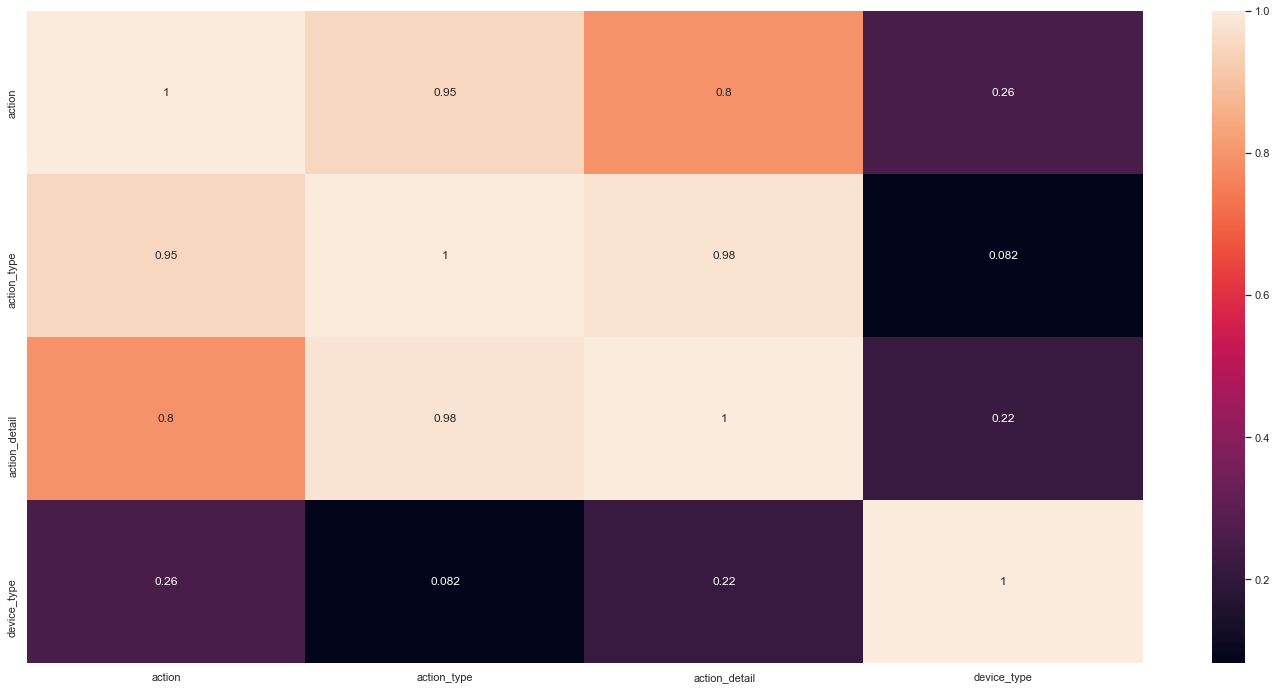

In [202]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 3. Feature Engineering

In [203]:
df2 = df1.copy()

In [204]:
df2.dtypes

date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [ ]:
# ============ First Active ========================

# ============ First Booking ======================

# ============ First Account Created ==============


# 4. Filter

In [166]:
df3 = df2.copy()

## 3.1. Filtering rows

In [169]:
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## 3.2. Filtering Columns

# 4. Pre-Modeling

In [170]:
df3 = df2.copy()

In [171]:
# dummie variables
df3_dummies = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))

In [172]:
# join id and country
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummies], axis=1)

In [173]:
df3.shape

(122636, 125)

In [174]:
df3

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_CoolNovo,first_browser_Firefox,first_browser_IE,first_browser_IE Mobile,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
1,820tgsjxq7,NDF,2011-05-25,2009-05-23 17:48:09,2015-06-29,38,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,lsw9q7

# 5. Feature Selection

In [175]:
cols_drop = ['id', 'date_account_created','timestamp_first_active', 'date_first_booking'] # dates
df4 = df3.drop(cols_drop, axis=1)

In [176]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

# 6. ML Models

In [177]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 6.1. Baseline Model

***random*** — Generate pseudo-random numbers:

random.choices(population, weights=None, *, cum_weights=None, k=1)
***Return a k sized list of elements chosen from the population with replacement***. If the population is empty, raises IndexError.

***If a weights sequence is specified, selections are made according to the relative weights***. Alternatively, if a cum_weights sequence is given, the selections are made according to the cumulative weights (perhaps computed using itertools.accumulate()). For example, the relative weights [10, 5, 30, 5] are equivalent to the cumulative weights [10, 15, 45, 50]. Internally, the relative weights are converted to cumulative weights before making selections, so supplying the cumulative weights saves work.

***If neither weights nor cum_weights are specified, selections are made with equal probability***. If a weights sequence is supplied, it must be the same length as the population sequence. It is a TypeError to specify both weights and cum_weights.

The weights or cum_weights can use any numeric type that interoperates with the float values returned by random() (that includes integers, floats, and fractions but excludes decimals). Behavior is undefined if any weight is negative. A ValueError is raised if all weights are zero.

For a given seed, the choices() function with equal weighting typically produces a different sequence than repeated calls to choice(). The algorithm used by choices() uses floating point arithmetic for internal consistency and speed. The algorithm used by choice() defaults to integer arithmetic with repeated selections to avoid small biases from round-off error.

In [178]:
# population list
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
# list of weights in the same order as population
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# size of the list generated
k_num = y_test.shape[0]

yhat_random = random.choices(population = country_destination_list,
                             weights=country_destination_weights,
                             k=k_num)

Accuracy: 0.3610159817351598
Balanced Accuracy: 0.08360302410029193
Kappa Score: 0.001987976944519576
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01        87
          CA       0.01      0.01      0.01       216
          DE       0.01      0.01      0.01       164
          ES       0.00      0.00      0.00       319
          FR       0.03      0.02      0.03       736
          GB       0.01      0.01      0.01       361
          IT       0.03      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.07      0.07      0.07      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

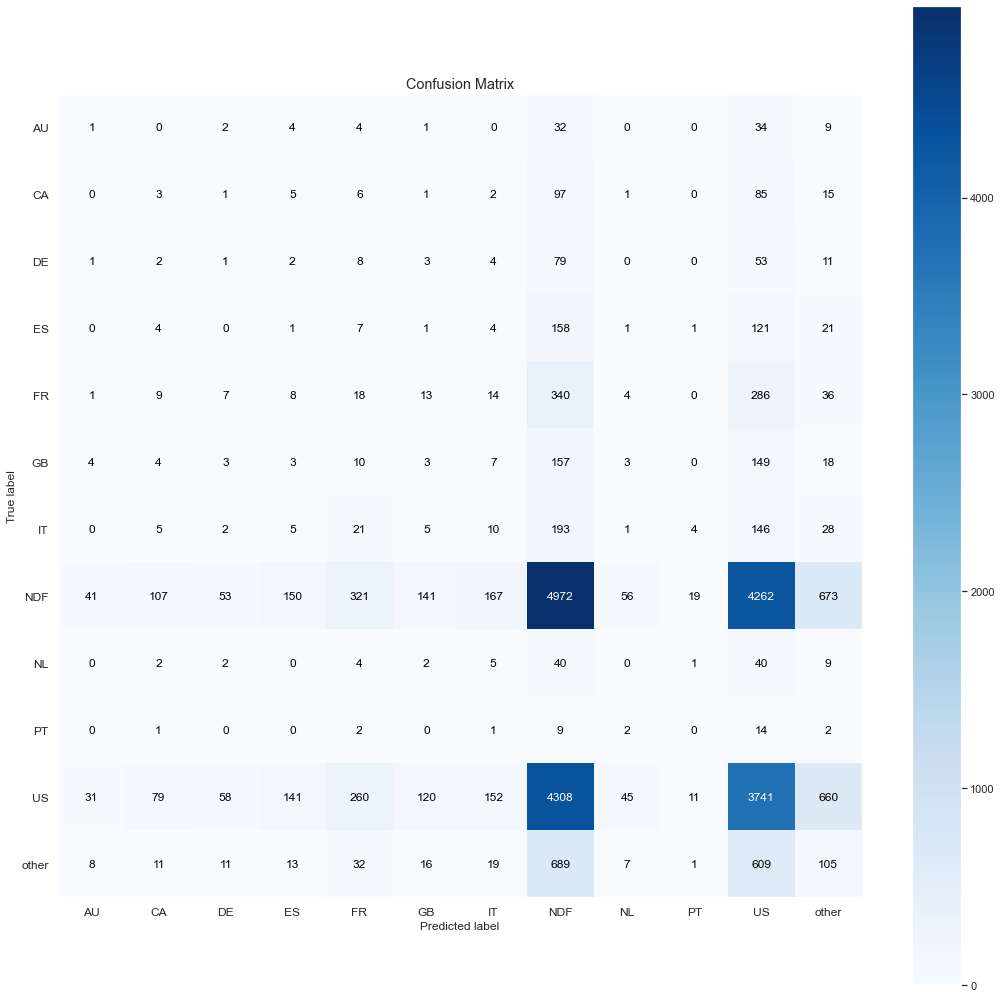

In [179]:
# BASELINE MODEL PERFORMANCE
# accuracy: In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))
# balanced accuracy: The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
balance_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balance_acc_random))
# kappa metrics: This function computes Cohen’s kappa [1], a score that expresses the level of agreement between two annotators on a classification problem. It is defined as
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))
# classification report: Build a text report showing the main classification metrics.
print(m.classification_report(y_test, yhat_random))
# confusion matrix: Compute confusion matrix to evaluate the accuracy of a classification.
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(18,18))

## 6.2. Neural Network

In [189]:
y_train.unique()

array(['other', 'NDF', 'US', 'IT', 'DE', 'FR', 'GB', 'ES', 'AU', 'CA',
       'NL', 'PT'], dtype=object)

In [180]:
y_train.values.reshape(-1,1)

array([['other'],
       ['NDF'],
       ['NDF'],
       ...,
       ['US'],
       ['NDF'],
       ['FR']], dtype=object)

In [181]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [184]:
y_train_nn.shape

(98108, 12)

In [183]:
X_train.shape

(98108, 120)

In [190]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.3153 - accuracy: 0.5207
Epoch 2/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2816 - accuracy: 0.5290
Epoch 3/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2745 - accuracy: 0.5301
Epoch 4/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2702 - accuracy: 0.5310
Epoch 5/100
3066/3066 [==============================] - 10s 3ms/step - loss: 1.2672 - accuracy: 0.5333
Epoch 6/100
3066/3066 [==============================] - 10s 3ms/step - loss: 1.2654 - accuracy: 0.5337
Epoch 7/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2641 - accuracy: 0.5355
Epoch 8/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2630 - accuracy: 0.5355
Epoch 9/100
3066/3066 [==============================] - 8s 3ms/step - loss: 1.2619 - accuracy: 0.5360
Epoch 10/100
3066/3066 [==============================] - 9s 3ms/step -

3066/3066 [==============================] - 9s 3ms/step - loss: 1.2429 - accuracy: 0.5395
Epoch 86/100
3066/3066 [==============================] - 8s 3ms/step - loss: 1.2429 - accuracy: 0.5404
Epoch 87/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2426 - accuracy: 0.5413
Epoch 88/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2425 - accuracy: 0.5402: 
Epoch 89/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2426 - accuracy: 0.5406
Epoch 90/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2424 - accuracy: 0.5411
Epoch 91/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2423 - accuracy: 0.5410
Epoch 92/100
3066/3066 [==============================] - 9s 3ms/step - loss: 1.2427 - accuracy: 0.5410
Epoch 93/100
3066/3066 [==============================] - 10s 3ms/step - loss: 1.2422 - accuracy: 0.5412
Epoch 94/100
3066/3066 [==============================] - 9s 3ms/step - lo

In [191]:
# prediction
pred_nn = model.predict(X_test)
# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)
# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.5338388780169602
Balanced Accuracy: 0.10549340418244192
Kappa Score: 0.19420254367328593


c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.00      0.00      0.00       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       0.56      0.69      0.62     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.50      0.58      0.53      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.53     24528
   macro avg       0.09      0.11      0.10     24528
weighted avg       0.45      0.53      0.49     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

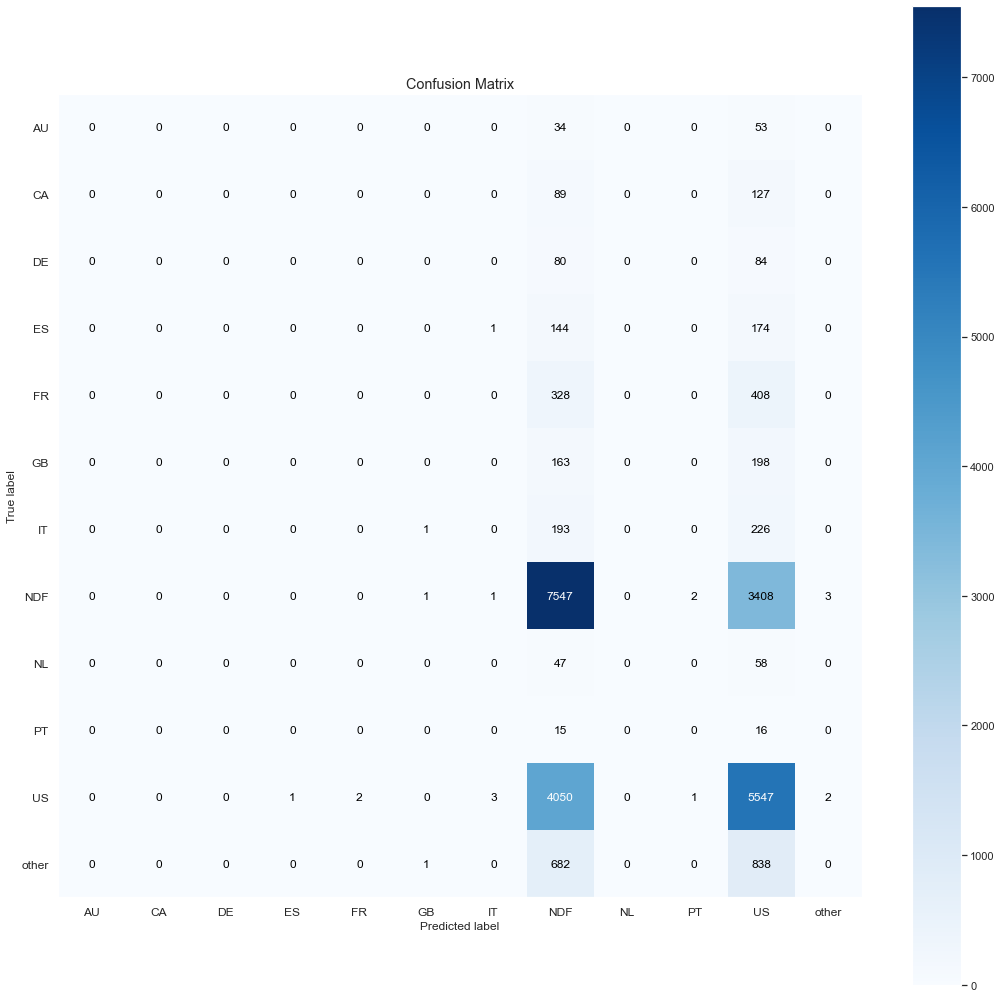

In [192]:
# accuracy: In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# balanced accuracy: The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat_nn)
print('Balanced Accuracy: {}'.format(balance_acc_nn))

# kappa metrics: This function computes Cohen’s kappa [1], a score that expresses the level of agreement between two annotators on a classification problem. It is defined as
kappa_nn = m.cohen_kappa_score(y_test, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# classification report: Build a text report showing the main classification metrics.
print(m.classification_report(y_test, yhat_nn))

# confusion matrix: Compute confusion matrix to evaluate the accuracy of a classification.
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

## NN perfomance - Cross-Validation

In [193]:
x_train = X_train

In [195]:
# generate k-fold for neural network classification:
        # Stratified K-Folds cross-validator, Provides train/test indices to split data in train/test sets. 
        # This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [196]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                  np.round( np.std( balanced_acc_list  ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                      np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.11 +/- 0.0009
Avg Kappa: 0.1913 +/- 0.0066
